# Assignment 1 - Logistic Regression with a Neural Network mindset

In this assignment, you will learn how to build the general architecture of a learning algorithm, including:
 
 - Calculating the cost function and its gradient
 
 - Using an optimization algorithm (gradient descent)
 
 - Gather all the functions above into a main model function, in the right order.

Run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import scipy
import sklearn
import sklearn.datasets

np.random.seed(1) # set a seed so that the results are consistent

## Dataset

For simplicity, you will start to work with a small dataset of 2D samples. The following code loads them into variables `X` and `Y`.

In [2]:
N = 200
X, y = sklearn.datasets.make_moons(n_samples=N, noise=0.05, random_state=0)

Visualize the dataset into a scatter plot using matplotlib. The data contains some red (label y=0) and some blue (y=1) points.

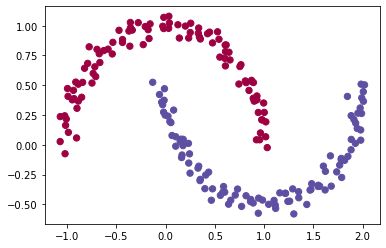

In [3]:
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.Spectral);

## Logistic regression

Your goal is to build a logistic regression classifier that performs reasonably well on the provided dataset. 

**Remember:** Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so !

### 1 - Logistic model

The logistic model for binary classification is mathematically defined as:

$$
f_{\rm w}({\rm x}) = {\sf sigmoid}({\rm w}^\top{\rm x}) = {\sf sigmoid}(w_0 + w_1 x_1 + \dots + w_Q x_Q)
$$

You have already implemented this function in the Numpy tutorial. Now, it's time to see it in action.

In [4]:
def logistic_prediction(w, x):
    """Calculates the logistic prediction for each row of the input x.
     
    Arguments:
    w -- A numpy vector of shape (Q+1,)
    x -- A numpy matrix of shape ( N, Q)

    Returns:
    s -- A numpy vector of shape (N,)
    """
    
    wx = w[0] + np.dot(x, w[1:])
    s  = 1 / (1 + np.exp(-wx))
        
    return s

Before implementing the training algorithm for logistic regression, let's see if you can "manually" find some good values for $w=[w_0, w_1, w_2]^\top$. To do so, you will evaluate the logistic model by plotting its decision boundary, that is

$$
y_{\sf pred} = 
\begin{cases}
1 &\quad\textrm{if }\; f_{\rm w}({\rm x}) \ge 0.5\\[0.5em]
0 &\quad\textrm{if }\; f_{\rm w}({\rm x}) < 0.5\\
\end{cases}
$$

Run the following code.

In [5]:
def plot_decision_boundary(w, X, y, expand_features=lambda x: x):
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict the function value for the whole grid
    Z = logistic_prediction(w,expand_features(grid)) > 0.5
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    plt.ylabel('X_2')
    plt.xlabel('X_1')
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

Now, you can visualize the decision boundary for some fixed values of $w=[w_0, w_1, w_2]^\top$.

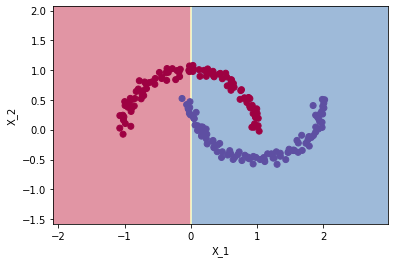

In [6]:
w = np.array([0,1,0])

plot_decision_boundary(w, X, y)

---
**Exercise**: Find the values of $w=[w_0, w_1, w_2]^\top$ leading to the best classification of the dataset. 

Accuracy: 89.00% (percentage of correctly classified points)


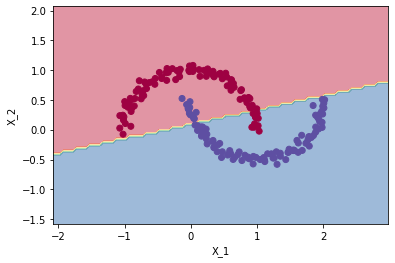

In [9]:
### START CODE HERE ### 
w = np.array([0.5,  1.3 ,-5.4])  # 1,0.9,-5 is also 89% change these values and rerun the cell
### END CODE HERE ###

# show bondary
plot_decision_boundary(w, X, y)

# predictions on dataset
y_hat = logistic_prediction(w, X) > 0.5

# print accuracy
acc = np.sum( y*y_hat + (1-y)*(1-y_hat) )
print('Accuracy: {:2.2f}% (percentage of correctly classified points)'.format(acc*100/len(y)))

**Expected Output**: 

<table style = "width:40%">
    <tr>
    <td>** Accuracy **</td> 
        <td> 89 % </td> 
    </tr>

</table>

In [10]:
np.testing.assert_almost_equal(acc/len(y), 0.89) 

As you may have noticed, logistic regression is a **linear classifier**, meaning that its decision boundary can only be a straight line. Therefore, since the dataset is not linearly separable, you can never find a combination of parameters $w=[w_0, w_1, w_2]^\top$ leading to a 100% accuracy. Later in this assignment, you will see that you can turn logistic regression into a nonlinear model through feature transformation, which allows you to achieve a better accuracy on this dataset.

### 2 - Logarithmic cost function (binary cross-entropy)

Now, you will implement the cost function for logistic regression, which serves to help you finding the "best values" for parameters $w=[w_0, w_1, w_2]^\top$. 

Recall that you are given a training set, provided as a matrix of observations $X \in \mathbb{R}^{N\times Q}$ and a vector of labels $y\in\mathbb{R}^{N}$. 

$$ 
X = \begin{bmatrix}
\_\!\_\; {{\rm x}^{(1)}}^\top \_\!\_ \\
\vdots\\
\_\!\_\; {{\rm x}^{(N)}}^\top \_\!\_ \\
\end{bmatrix} 
\qquad\qquad
y = \begin{bmatrix}
y^{(1)}\\
\vdots\\
y^{(N)}
\end{bmatrix}
$$


For a fixed $w$, the cost function is computed as follows.

 - The logistic model is evaluated on every observation ${\rm x}^{(n)}$
  
$$ 
\begin{bmatrix}
a^{(1)}\\
\vdots\\
a^{(N)}
\end{bmatrix}
=
\begin{bmatrix}
{\sf sigmoid}\big({\rm w}^T {\rm x}^{(1)}\big)\\
\vdots\\
{\sf sigmoid}\big({\rm w}^T {\rm x}^{(N)}\big)
\end{bmatrix} 
= {\sf sigmoid}\big(X{\rm w}\big)
$$
 
 
- Every prediction $a^{(n)}$ is compared to the corresponding label $y^{(n)}$
  
$$
\begin{bmatrix}
\mathcal{C}\big(a^{(1)}, y^{(1)}\big)\\
\vdots\\
\mathcal{C}\big(a^{(N)}, y^{(N)}\big)
\end{bmatrix}
=
\begin{bmatrix}
- y^{(1)} \log\big(a^{(1)}\big) - \big(1-y^{(1)}\big) \log\big(1-a^{(1)}\big)\\
\vdots\\
- y^{(N)} \log\big(a^{(N)}\big) - \big(1-y^{(N)}\big) \log\big(1-a^{(N)}\big)\;
\end{bmatrix}
= - y \circ \log(A) - (1-y) \circ \log(1-A)
$$


 - The cost is averaged over all training examples
 
 
 $$ J({\rm w}) = \frac{1}{N} \sum_{n=1}^N \mathcal{C}\big(a^{(n)}, y^{(n)}\big) $$
 
 
*NOTE that $({\rm x}^{(n)},y^{(n)})$ denotes the $n$-th element in the dataset (it does **not** mean $x$ or $y$ to the power of $n$).*

---
**Exercise:** Implement a function `cost_function()` that evaluates the binary cross-entropy. The code must be vectorized.

**Debugging tip**: As you program, don't forget to divide the cost by the number of training examples.

In [12]:
def cost_function(w, X, y):
    """
    Implements the cost function for logistic regression.

    Arguments:
    w -- weights, a numpy vector of size (Q+1,)
    X -- dataset, a numpy matrix of size (number of examples, Q)
    y -- labels,  a numpy vector of size (number of examples, Q)

    Return:
    cost -- logistic regression cost, a scalar
    """
    
    ### START CODE HERE ### (≈ 3 lines of code)
    
    # Step 1 - Compute predictions (use your function logistic_prediction)
    a = logistic_prediction(w, X)
    
    # Step 2 - Compute costs
    c = np.sum(-y * np.log(a) - (1 - y) * np.log(1 - a))
    
    # Step 3 - Compute average
    n = y.shape[0]#y.size
    J = c /n
    
    ### END CODE HERE ###
    assert J.shape == ()
    
    return J

In [13]:
ww = np.array([2., 1., 2.])
XX, yy = np.array([[1.,2.,-1.],[3.,4.,-3.2]]).T, np.array([1,0,1])
cost = cost_function(ww, XX, yy)
print ("cost = " + str(cost))

cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">

<tr>
    <td>  ** cost **  </td>
    <td> 5.801545319394553 </td>
</tr>

</table>

In [14]:
np.testing.assert_almost_equal(cost, 5.8015453) 

---
**Exercise**: Find the values of $w=[w_0, w_1, w_2]^\top$ yielding the minimum value for the cost function $J(w)$. 

**Hint**: Run the following code, and use the contour plot to locate the minimium.

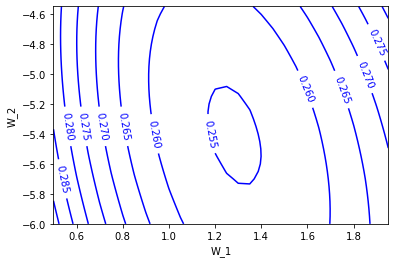

In [15]:
def plot_cost_function(X, y):
    
    # Fix w0
    w0 = 0.5
    
    # Generate a grid for w1 and w2
    h = 0.05
    w1_range = np.arange(0.5, 2, h)
    w2_range = np.arange(-6,-4.5, h)
    ww1, ww2 = np.meshgrid(w1_range, w2_range)
    
    # Compute the cost function for the whole grid
    cost = np.empty(shape=ww1.shape)
    for i1 in range(0,w2_range.size):
        for i2 in range(0,w1_range.size):
            w1 = ww1[i1,i2]
            w2 = ww2[i1,i2]
            w = np.array([w0, w1, w2])
            cost[i1,i2] = cost_function(w,X,y)
    
    # Plot the contour and training examples
    levels = np.arange(0.2, 0.3, 0.005)
    CS = plt.contour(ww1, ww2, cost, levels, colors='b')
    plt.clabel(CS, inline=1, fontsize=10)
    plt.ylabel('W_2')
    plt.xlabel('W_1')
    return

# show contours
plot_cost_function(X, y)

Weights: [ 0.5  1.3 -5.4]
Cost: 0.254527 
Accuracy: 89.00 % (percentage of correctly classified points)


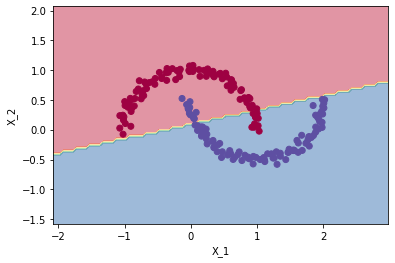

In [18]:
### START CODE HERE ###
w = np.array([0.5, 1.3, -5.4]) # Change w1 and w2, but fix w0 = 0.5
### END CODE HERE ###

# print weighs
print ('Weights: ' + str(w))

# compute the cost function
cost = cost_function(w, X, y)

# print cost
print ('Cost: %f ' % (cost))

# show bondary
plot_decision_boundary(w, X, y)

# predictions on dataset
y_hat = logistic_prediction(w, X) > 0.5

# print accuracy
acc = np.sum( y*y_hat + (1-y)*(1-y_hat) )
print ('Accuracy: %2.2f ' % (acc*100/y.size) + '% ' + "(percentage of correctly classified points)")

**Expected Output**:

<table style="width:50%">

<tr>
    <td>  ** Weights **  </td>
    <td> [0.5, 1.3, -5.4] </td>
</tr>
<tr>
    <td>  ** Cost **  </td>
    <td> 0.254527 </td>
</tr>
<tr>
    <td>  ** Accuracy **  </td>
    <td> 89% </td>
</tr>

</table>

In [19]:
np.testing.assert_almost_equal(cost, 0.254527, decimal=5) 

As you may have noticed, the cost function minimum corresponds to the vector $w=[w_0, w_1, w_2]^\top$ yielding the best accuracy in terms of classification.

### 3 - Gradient descent

Training a logistic regression classifier amounts to finding the vector $\bar{{\rm w}}$ that minimizes the binary cross-entropy function:

$$\bar{{\rm w}} = \operatorname*{argmin}_{{\rm w}} \, J({\rm w}).$$

This can be done through *gradient descent*, an iterative method that performs the following update at each iteration:

$$ 
(\forall i \in \mathbb{N})\qquad {\rm w}^{[i+1]} = {\rm w}^{[i]} - \alpha_i \nabla J\big({\rm w}^{[i]}\big)
$$

where $\nabla J$ denotes the gradient of $J$ (the vector of its partial derivatives):

$$\nabla J\big({\rm w}) = \begin{bmatrix}
\dfrac{\partial J({\rm w})}{\partial w_0}\\
\dfrac{\partial J({\rm w})}{\partial w_1}\\
\vdots\\
\dfrac{\partial J({\rm w})}{\partial w_Q}
\end{bmatrix}.$$

At each iteration $i$ of the gradient descent method, the parameters ${\rm w}^{[i]}$ come closer to the optimal values corresponding to the lowest cost $J\big(\bar{{\rm w}}\big)$.

---
**Exercise**: Implement the gradient of the cost function.

**Hint**: Here are the two gradient formulas you will be using: 

$$ \frac{\partial J({\rm w})}{\partial w_0} = \frac{1}{N} \sum_{n=1}^N \big(a^{(n)}-y^{(n)}\big)
\qquad\qquad
\frac{\partial J({\rm w})}{\partial w_j} = \frac{1}{N} \sum_{n=1}^N x_j^{(n)} \big(a^{(n)}-y^{(n)}\big)$$

where $a^{(n)}$ was defined in the previous section.

In [20]:
def cost_gradient(w, X, y):
    """
    Implement the gradient of the cost function.

    Arguments:
    w -- weights, a numpy vector of size (Q+1,)
    X -- dataset, a numpy matrix of size (number of examples, Q)
    y -- labels,  a numpy vector of size (number of examples, Q)

    Return:
    grad -- gradient with respect to w, a numpy vector of size (Q+1,)
    """

    grad = np.zeros(w.shape)
    n = y.size 
    ### START CODE HERE ### (≈ 3 lines of code)
    
    # Step 1 - Compute predictions (use your function logistic_prediction
    A = logistic_prediction(w, X)
    
    # Step 2 - Compute a-y
    D = A-y
    
    # Step 3 - Compute gradients
    grad[0]  = np.sum(D)/n
    grad[1:] = np.dot(X.T,(D))/n
    
    ### END CODE HERE ##
    assert(grad.shape == w.shape)
        
    return grad

In [21]:
ww = np.array([2., 1., 2.]) 
XX, yy = np.array([[1.,2.,-1.,5],[3.,4.,-3.2,1]]).T, np.array([1,0,1,1])
dw = cost_gradient(ww, XX, yy)
print ("dw = " + str(dw))

dw = [1.06083496e-03 7.48687768e-01 1.79627344e+00]


**Expected Output**:

<table style="width:70%">
    <tr>
        <td>  ** dw **  </td>
      <td> [0.001060834, 0.748687, 1.796273] </td>
    </tr>
</table>

In [22]:
np.testing.assert_almost_equal(dw, [0.001060834, 0.748687, 1.796273], decimal=5) 

---
**Exercise**: Write down the optimization function. The goal is to learn $w$ by minimizing the cost function $J(w)$.

**Debugging tips**:

- As you program, make sure you understand what you are trying to optimize and what is being updated. Keep in mind that the cost is parameterized by the vector $w$. Hence, we minimize the value of $J(w)$ by changing the values of $w$, not by changing the data in $X$ and $y$. 


- A good way to verify that gradient descent is working correctly is to look at the value of $J(w)$. Assuming you have implemented `cost_gradient()` and `cost_function()` correctly, your value of $J(w)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [23]:
def optimize(w, X, y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy vector of size (Q+1,)
    X -- dataset, a numpy matrix of size (number of examples, Q)
    y -- labels,  a numpy vector of size (number of examples, Q)
    num_iterations -- number of iterations of the optimization loop
    learning_rate  -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    w     -- optimal vector of weights
    grad  -- vector containing the gradient at the optimal point
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters.
        2) Update the vector w using gradient descent rule.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        ### START CODE HERE ### 
        
        # Cost and gradient calculation (≈ 2 lines of code)
        cost = cost_function(w,X, y)
        grad = cost_gradient(w, X, y)
                
        # update rule (≈ 1 lines of code)
        w = w-learning_rate * grad
        
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, grad, costs

In [24]:
w = np.array([2., 1., 2.])
XX, yy = np.array([[1.,2.,-1.],[3.,4.,-3.2]]).T, np.array([1,0,1])
w, dw, costs = optimize(w, XX, yy, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w  = " + str(w))
print ("dw = " + str(dw))

w  = [1.92535983 0.19033591 0.12259159]
dw = [0.2191945  0.67752042 1.41625495]


**Expected Output**: 

<table style="width:60%">
<tr>
   <td> **w** </td>
   <td>[1.92535983008, 0.19033591, 0.12259159] </td>
</tr>

<tr>
   <td> **dw** </td>
   <td> [0.219194504541, 0.67752042, 1.41625495] </td>
</tr>

</table>

In [25]:
np.testing.assert_almost_equal(w,  [1.92535, 0.190335, 0.122591], decimal=5)
np.testing.assert_almost_equal(dw, [0.219194, 0.677520, 1.41625], decimal=5)

---
**Exercise**: Find the optimal values of $w$ on the "two moons" dataset, compute the accuracy on the training set, and plot the decision boundary.

**Hint**: You just need to call the functions used so far.

w = [ 0.99990472  1.13510701 -6.14220251]

Cost = 0.24992530509104538

Accuracy: 88.50 % (percentage of correctly classified points)


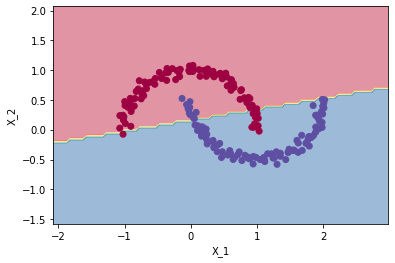

In [26]:
Q     = X.shape[1] # number of features
it    = 5000       # iterations
alpha = 0.5        # learning rate

# Step 1 - Find the optimal w 
w = np.zeros((Q+1,))
### START CODE HERE ### 
w, dw, costs = optimize(w, X, y, it, alpha, print_cost = False)
### END CODE HERE ### 

print("w = " + str(w) + "\n")
print("Cost = " + str(costs[-1]) + "\n")

# Step 2 - Print the accuracy 
### START CODE HERE ### 
y_hat = logistic_prediction(w, X) > alpha
acc = np.sum( y*y_hat + (1-y)*(1-y_hat) )
### END CODE HERE ### 

print ('Accuracy: %2.2f ' % (acc*100/len(y)) + '% ' + "(percentage of correctly classified points)")

# Step 3 - Plot the decision boundary
plt.figure()
### START CODE HERE ### 
plot_decision_boundary(w, X, y)
### END CODE HERE ###


**Expected Output**: 

<table style="width:50%">
<tr>
   <td> **w** </td>
   <td>[0.99990472, 1.13510701, -6.14220251] </td>
</tr>

<tr>
   <td> **Cost** </td>
   <td> 0.249925 </td>
</tr>

<tr>
   <td> **Accuracy** </td>
   <td> 88.50% </td>
</tr>

</table>

In [27]:
np.testing.assert_almost_equal(w, [0.999904, 1.135107, -6.142202], decimal=5)
np.testing.assert_almost_equal(acc/len(y), 0.885)

### 4 - Feature Transformation

You have understood by now that logistic regression is a linear classifier, because the decision boundary is a straight line. But what if you need a nonlinear classifier? You can still use logistic regression with nonlinear feature transformation! Here's how it works:

- Choose $M$ nonlinear functions that can be parameterized or unparameterized: 

$$ \phi_m \colon \mathbb{R}^Q \to \mathbb{R}. $$ 

- Define the logistic model on the features transformed by functions $\phi_m$:

$$
f_{\rm w}({\rm x}) = {\sf sigmoid}\big(w_0 + w_1 \, \phi_1({\rm x}) + \dots + w_M \phi_M({\rm x})\big) = {\sf sigmoid}\big({\rm w}^\top\phi({\rm x})\big) 
$$

This is the approach used by many popular nonlinear models, including neural networks, boosting, etc. In the following, you will focus on one of the simplest and most intuitive transformations: the **exponentitation**. The idea here is to augment the original features ${\rm x} = [x_1,\dots,x_Q]$ with their exponentiated versions, such as $x_i^2, x_q^3, \dots$ for every $i$. Mathematically, the feature transformation is defined as:

$$ \phi({\rm x}) = \left[ x_1,\dots,x_Q, x_1^2,\dots,x_Q^2,\dots, x_1^p,\dots,x_Q^p \right]  $$

where $p\ge1$ is an hyper-parameter to be fixed, which determines the size $M=QP$ of the transformed feature vector $\phi({\rm x})$.

---

**Exercise:** Implement a function that augments a matrix of observations by exponentiation:

$$ 
X = \begin{bmatrix}
\_\!\_\; {{\rm x}^{(1)}}^\top \_\!\_ \\
\vdots\\
\_\!\_\; {{\rm x}^{(N)}}^\top \_\!\_ \\
\end{bmatrix} \in \mathbb{R}^{N\times Q}
\qquad\rightarrow\qquad
\phi(X) = \begin{bmatrix}
\_\!\_\; \phi({\rm x}^{(1)})^\top \_\!\_ \\
\vdots\\
\_\!\_\; \phi({\rm x}^{(N)})^\top \_\!\_ \\
\end{bmatrix} \in \mathbb{R}^{N\times QP}
$$

**Hint:** You may find useful the numpy function [hstack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html) used together with the [list comprehension](https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions).

In [28]:
def expand_features(X, p):
    """
    This function augments X by exponentiation
    
    Arguments:
    X -- dataset, a numpy matrix of size (number of examples, Q)
    p -- power, a scalar
    
    Returns:
    TX -- expanded dataset, a numpy matrix of size (number of examples, Q*p)
    """
    
    N,Q = X.shape
    
    ### START CODE HERE ### 
    TX = np.hstack((np.hstack((X,X*X)),X*X*X))
    ### END CODE HERE ### 
    
    assert TX.shape == (N,Q*p)
    
    return TX

In [29]:
XX = np.array([[1.,2.,-1.],[3.,4.,-3.2]]).T
TX = expand_features(XX, 3)

print("TX = \n" + str(TX))

TX = 
[[  1.      3.      1.      9.      1.     27.   ]
 [  2.      4.      4.     16.      8.     64.   ]
 [ -1.     -3.2     1.     10.24   -1.    -32.768]]


**Expected Output**: 

<table>
    <tr>
       <td> **TX** </td>
       <td> [ [1, 3, 1, 9, 1, 27], [2, 4, 4, 16, 8, 64], [-1, -3.2, 1, 10.24, -1, -32.768] ] </td>
    </tr>

</table>

In [30]:
np.testing.assert_almost_equal(TX, np.array([[1, 3, 1, 9, 1, 27], 
                                             [2, 4, 4, 16, 8, 64], 
                                             [-1, -3.2, 1, 10.24, -1, -32.768]]))

The code below tests the logistic regression classifier with features exponentiated by a power of 3. You can see that the decision boundary is nonlinear (resembling to a third-degree polynomial), and the accuracy is 100%. 

w = [ 4.7852 -3.5646 -7.5202 -7.2725 -0.2518  5.3667 -3.1554]

Cost = 0.031576219096222

Accuracy: 100.00 % (percentage of correctly classified points)


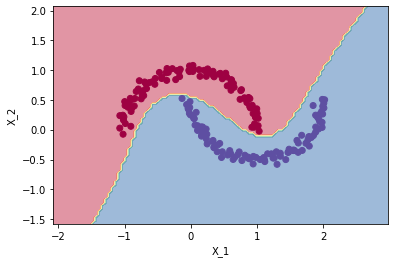

In [31]:
P = 3

XX = expand_features(X, P)
Q = XX.shape[1]

w = np.zeros((Q+1,))
w, grad, costs = optimize(w, XX, y, 2000, alpha)

y_hat = logistic_prediction(w, XX) > 0.5
acc = np.sum( y*y_hat + (1-y)*(1-y_hat) )

plt.figure()
plot_decision_boundary(w, X, y, lambda x: expand_features(x,P))

print("w = " + str(np.round(w,4)) + "\n")
print("Cost = " + str(costs[-1]) + "\n")
print ('Accuracy: %2.2f ' % (acc*100/len(y)) + '% ' + "(percentage of correctly classified points)")

## Image classification

Up to this point, you have learned how to optimize the cost function with gradient descent in order to find the optimal parameters of a logistic regression classifier, and you have used it to predict the labels for a given set of examples. Now, you will use the logistic classifier to solve a real problem.

**Problem Statement**: You are given a dataset ("data.h5") containing:
 - a training set of images labeled as **cat (y=1)** or **non-cat (y=0)**
 - a test set of images labeled as **cat (y=1)** or **non-cat (y=0)**
 - each image is of shape **(64, 64, 3)**, where 3 is for the 3 channels (RGB). 

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [32]:
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
test_dataset  = h5py.File('datasets/test_catvnoncat.h5', "r")

train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

We added "_orig" at the end of image datasets because we are going to preprocess them. After preprocessing, we will end up with `train_set_x` and `test_set_x` (the labels `train_set_y` and `test_set_y` don't need any preprocessing).

Each line of your `train_set_x_orig` and `test_set_x_orig` is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = 1, it's a 'cat' picture.


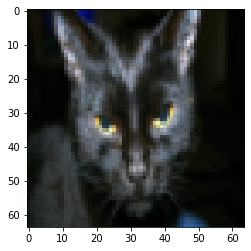

In [33]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[index]) + ", it's a '" + classes[np.squeeze(train_set_y[index])].decode("utf-8") +  "' picture.")

Many software bugs in machine learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
   - m_train (number of training examples)
   - m_test (number of test examples)
   - num_px (= height = width of a training image)

Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [34]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


**Expected Output**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


In [35]:
assert m_train == 209
assert m_test == 50
assert num_px == 64

For convenience, you should now reshape images of shape (num_px, num_px, 3) in vectors of shape (1, num_px $*$ num_px $*$ 3). After this, our training (and test) dataset will be a matrix where each row represents a flattened image. There should be m_train (respectively m_test) rows.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (1, num\_px $*$ num\_px $*$ 3).

**Reminder**: Recall that `train_set_x_orig` and `test_set_x_orig` are numpy-arrays of shape (m_train, num_px, num_px, 3). 

**Hint**: A trick when you want to flatten an array of shape (a,b,c,d) to a matrix of shape (a, b$*$c$*$d) is to use: 

```python
X_flatten = X.reshape(X.shape[0], -1)
```

In [37]:
### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0,0:5]))

train_set_x_flatten shape: (209, 12288)
train_set_y shape: (209,)
test_set_x_flatten shape: (50, 12288)
test_set_y shape: (50,)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (209, 12288)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(209,)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(50, 12288)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(50,)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

In [38]:
assert train_set_x_flatten.shape == (209, 12288)
assert train_set_y.shape == (209,)
assert test_set_x_flatten.shape == (50, 12288)
assert test_set_y.shape == (50,)

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [39]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

**What you need to remember.** Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

**Common pitfall.** An important point to make about the preprocessing is that any preprocessing statistics (e.g., the data mean) must only be computed on the training data, and then applied to the validation / test data. This means that computing the mean and subtracting it from every image across the entire dataset, and then splitting the data into train/val/test splits, would be a mistake. Instead, the mean must be computed only over the training data, and then subtracted equally from all splits (train/val/test).

### 1 - General Architecture of the learning algorithm

It's time to distinguish cat images from non-cat images using Logistic Regression. The following figure summarizes how it works.

---

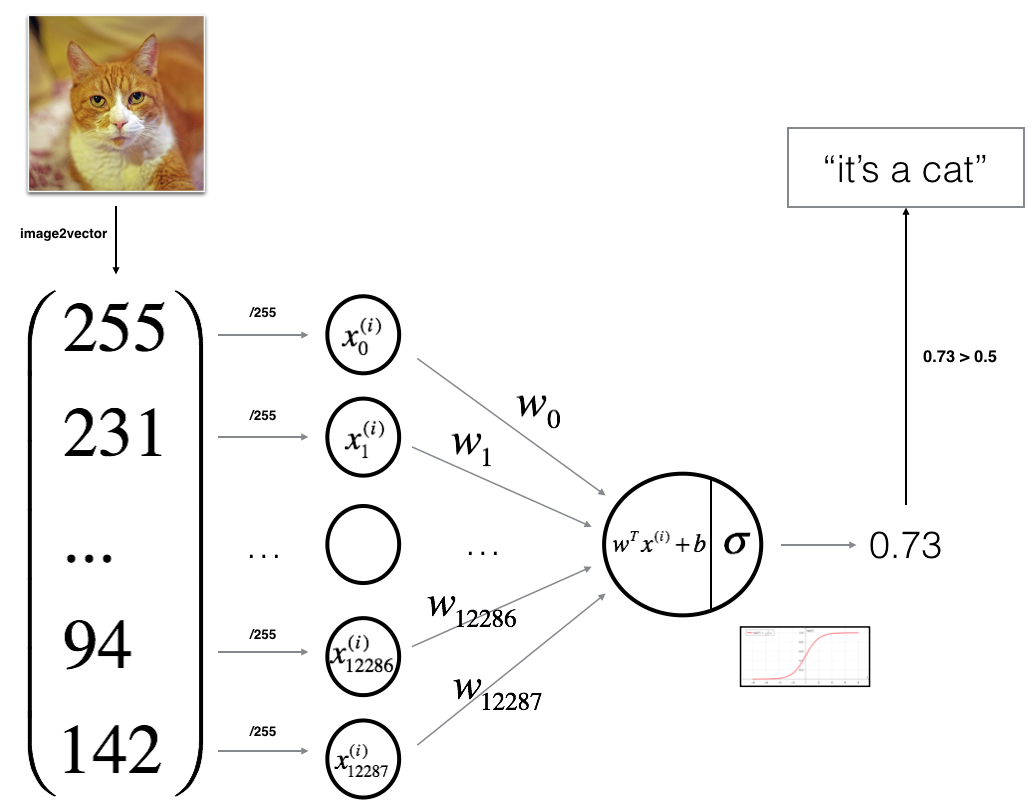

Next, you will carry out the following steps: 
 2. Initialize the model's parameters
 3. Learn the model's parameters by minimizing the cost (on the training set)
 4. Use the learned parameters to make predictions (on the test set)
 5. Analyse the results and conclude
 
 
You have already built 1-3 separately. You just need integrate them into one function called `model()`.

### 2 - Merge all functions into a model ##

While you have already implemented `logistic_prediction()`, the values returned by this function are between 0 and 1. Now, you need to convert them into binary decisions by thresholding, namely 

$$
y_{\sf pred} = 
\begin{cases}
1 &\quad\textrm{if }\; f_{\rm w}({\rm x}) \ge 0.5\\[0.5em]
0 &\quad\textrm{if }\; f_{\rm w}({\rm x}) < 0.5\\
\end{cases}
$$

**Exercise:** Implement a function `binary_decision()` that returns 0 or 1 according to the logistic prediction.

In [40]:
def binary_decision(w, x):
    '''
    Predict whether the label is 0 or 1 using the logistic prediction with parameters w
    
    Arguments:
    w -- weights, a numpy array of size (Q+1,)
    x -- inputs,  a numpy array of size (number of examples, Q)
    
    Returns:
    y -- binary decisions (0/1), a numpy array of size (number of examples,)
    '''
        
    ### START CODE HERE ### (≈ 2 line of code)
    
    # Step 1 - Logistic predictions. Use the function logistic_prediction(...)
    p = logistic_prediction(w,x)
    
    # Step 2 - Thresholding
    y = p>= 0.5
    ### END CODE HERE ###
    print(y)
    assert(y.shape == (x.shape[0],))
    
    return y

In [41]:
ww = np.array([-0.3, 0.1124579, 0.23106775]) 
xx = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]]).T

print ("predictions = " + str(binary_decision(ww, xx)))

[ True  True False]
predictions = [ True  True False]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [True, True, False]
         </td>  
   </tr>

</table>


In [42]:
np.testing.assert_equal(binary_decision(ww, xx), [True, True, False])

[ True  True False]


---
You will now see how the overall model is structured by putting together all the building blocks together, in the right order.

**Exercise:** Implement the model function.

In [43]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training inputs, a numpy array of shape (m_train, dim)
    Y_train -- training labels, a numpy array of shape (m_train, 1)
    X_test  -- test inputs, a numpy array of shape (m_test, dim)
    Y_test  -- test labels, a numpy array of shape (m_test, 1)
    num_iterations -- number of iterations to optimize the parameters
    learning_rate  -- learning rate used in gradient descent
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    dim = X_train.shape[1]
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros - see np.zeros(...) (≈ 1 line of code)
    # Step 1 - Find the optimal w 
    w = np.zeros((dim+1,))

    # Gradient descent (≈ 1 line of code)
    w, grads, costs = optimize(w, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test  = binary_decision(w,X_test)
    Y_prediction_train = binary_decision(w,X_train)

    ### END CODE HERE ###
    
    assert w.shape == (dim+1,)
        
    # Print train/test Errors
    print("")
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [44]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
[ True  True  True  True  True  True False  True  True  True False False
  True  True False  True False  True False False  True False False  True
  True  True  True False False  True False  True  True False  True False
 False  True False False  True False  True False  True False False  True


**Expected Output**: 

<table style="width:40%"> 

<tr>
    <td> **Cost after iteration 0 **  </td> 
    <td> 0.693147 </td>
</tr>
  <tr>
    <td> <center> $\vdots$ </center> </td> 
    <td> <center> $\vdots$ </center> </td> 
</tr>  
 <tr>
    <td> **Cost after iteration 1900 **  </td> 
    <td> 0.140872 </td>
</tr>
<tr>
    <td> **Train Accuracy**  </td> 
    <td> 99.04306220095694 % </td>
</tr>

<tr>
    <td>**Test Accuracy** </td> 
    <td> 70.0 % </td>
</tr>
</table> 




In [45]:
np.testing.assert_almost_equal(d["costs"][-1], 0.140872, decimal=5) 
np.testing.assert_almost_equal(100 - np.mean(np.abs(d["Y_prediction_train"] - train_set_y)) * 100, 99.043062, decimal=5) 
np.testing.assert_almost_equal(100 - np.mean(np.abs(d["Y_prediction_test"] - test_set_y)) * 100, 70, decimal=5) 

**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier in the next assignment!

Also, you see that the model is clearly overfitting the training data. Later in this course, you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

y = 1, you predicted that it is a "cat" picture.


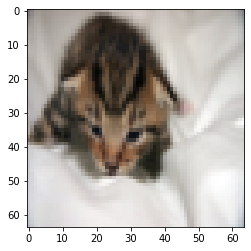

In [46]:
# Example of image classification
index = 1
plt.imshow(test_set_x[index,:].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function as a function of iterations.

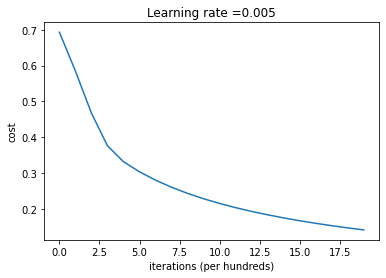

In [47]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

### 3 - Built-in logistic regression

Logistic regression is already implemented in [sklearn](http://scikit-learn.org/stable/). The code below uses sklearn's built-in function to train a logistic regression classifier on the dataset.

In [48]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression classifier
clf = LogisticRegression()
clf.fit(train_set_x, train_set_y.ravel())

# Prediction
pred_train = clf.predict(train_set_x)
pred_test  = clf.predict(test_set_x)

# Accuracy
score_train = clf.score(train_set_x, train_set_y)
score_test  = clf.score(test_set_x, test_set_y)

# Print accuracy
print("Train accuracy: {} %".format(100*score_train))
print("Test accuracy:  {} %".format(100*score_test))

Train accuracy: 100.0 %
Test accuracy:  72.0 %


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4 - Further analysis 

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
[ True  True  True  True  True  True False  True  True  True False False
  True  True False  True False  True False False  True False False  True
  True  True  True False False  True False  True  True False  True False
 False  True False False  True False  True False  True  True False  True
  True False]
[False False  True False False False False  True False False False  True
 False  True  True False False False False  True False False False False
  True  True False  True False  True False False False False False False
 False False  True False False  True  True False False False False  True
 False False  True False False False  True False  True  True False  True
  True  True False False False False False False  True False False  True
 False False False  True False False False False False False False  True
  True False False False  True False False False  True  True  True False
 False  True False False False False  True False  True False  True  True
  True  True  

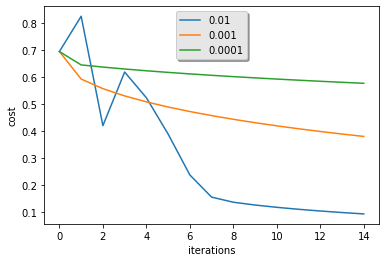

In [49]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In machine learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later lectures.) 


### 5 - Test with your own image

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
   1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
   2. Add your image to this Jupyter Notebook's directory, in the "images" folder
   3. Change your image's name in the following code
   4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

[False]
Your algorithm predicts a "non-cat" picture.


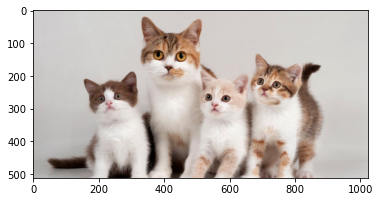

In [51]:
from skimage.transform import resize

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "cats.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = resize(image, (num_px,num_px), mode='constant').reshape((1, num_px*num_px*3))
my_predicted_image = binary_decision(d["w"], my_image)

plt.imshow(image)
print("Your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

[False]
Your algorithm predicts a "non-cat" picture.


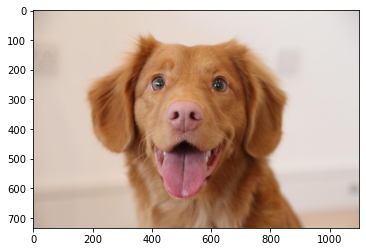

In [52]:
from skimage.transform import resize

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "dog.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = resize(image, (num_px,num_px), mode='constant').reshape((1, num_px*num_px*3))
my_predicted_image = binary_decision(d["w"], my_image)

plt.imshow(image)
print("Your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

[False]
Your algorithm predicts a "non-cat" picture.


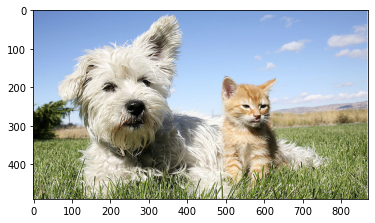

In [53]:
from skimage.transform import resize

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "cat_dog.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = resize(image, (num_px,num_px), mode='constant').reshape((1, num_px*num_px*3))
my_predicted_image = binary_decision(d["w"], my_image)

plt.imshow(image)
print("Your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

[False]
Your algorithm predicts a "non-cat" picture.


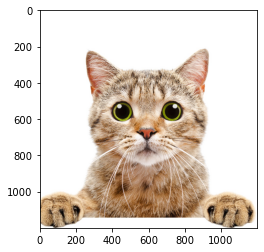

In [54]:
from skimage.transform import resize

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "cat.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = resize(image, (num_px,num_px), mode='constant').reshape((1, num_px*num_px*3))
my_predicted_image = binary_decision(d["w"], my_image)

plt.imshow(image)
print("Your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**What to remember from this assignment:**
- Preprocessing the dataset is important.
- Tuning the learning rate (which is an example of a "hyper-parameter") can make a big difference to the algorithm.

If you'd like, we invite you to try different things on this Notebook:
   - Play with the learning rate and the number of iterations
   - Try different initialization methods and compare the results
   - Test other preprocessings (center the data, or divide each row by its standard deviation)

**Credits:** 
- This assignment is partly based on Andrew Ng's course on Coursera.